In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 

In [4]:
df = pd.read_csv("vacancies.csv") 

In [5]:
# Создаем целевую переменную
df['salary'] = np.where(
    df['russian_salary_from'].notna() & df['russian_salary_to'].notna(),
    (df['russian_salary_from'] + df['russian_salary_to']) / 2,
    np.where(
        df['russian_salary_from'].notna(),
        df['russian_salary_from'],
        df['russian_salary_to']
    )
)

df = df.dropna(subset=['salary'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1673 entries, 4 to 5575
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1673 non-null   int64  
 1   title                1673 non-null   object 
 2   company_name         1673 non-null   object 
 3   currency             1673 non-null   object 
 4   experience           1673 non-null   object 
 5   type_of_employment   1673 non-null   object 
 6   work_format          1673 non-null   object 
 7   description          1673 non-null   object 
 8   skills               1673 non-null   object 
 9   address              1673 non-null   object 
 10  published_at         1673 non-null   object 
 11  archived             1673 non-null   bool   
 12  url                  1673 non-null   object 
 13  min_experience       1673 non-null   int64  
 14  max_experience       1643 non-null   float64
 15  salary_to            868 non-null    float6

In [7]:
df = df.drop(columns=[
    'id', 'company_name', 'currency', 'published_at', 
    'archived', 'url', 'salary_to', 'salary_from', 'experience', 'russian_salary_to', 'russian_salary_from', 
    'description', 'title'
])

In [9]:
df.columns

Index(['type_of_employment', 'work_format', 'skills', 'address',
       'min_experience', 'max_experience', 'salary'],
      dtype='object')

In [15]:
print(df[['min_experience', 'max_experience', 'salary']].corr())

                min_experience  max_experience    salary
min_experience        1.000000        0.971802  0.550029
max_experience        0.971802        1.000000  0.522721
salary                0.550029        0.522721  1.000000


Можно оставить только min_experience, так как кореляция между этими признаками очень высокая

In [18]:
df = df.drop(columns=['max_experience'])

In [20]:
df['type_of_employment'].value_counts()

type_of_employment
Полная занятость       1623
Частичная занятость      35
Проектная работа          9
Стажировка                6
Name: count, dtype: int64

In [22]:
df['type_of_employment']=df['type_of_employment'].replace('Частичная занятость', 'Другое')
df['type_of_employment']=df['type_of_employment'].replace('Проектная работа', 'Другое')
df['type_of_employment']=df['type_of_employment'].replace('Стажировка', 'Другое')
df['type_of_employment'].value_counts()

type_of_employment
Полная занятость    1623
Другое                50
Name: count, dtype: int64

In [24]:
df['work_format'].value_counts()

work_format
Полный день         1152
Удаленная работа     504
Гибкий график          8
Сменный график         8
Вахтовый метод         1
Name: count, dtype: int64

In [26]:
df['work_format']=df['work_format'].replace('Сменный график', 'Гибкий график')
df = df[df['work_format'] != 'Вахтовый метод']
df['work_format'].value_counts()

work_format
Полный день         1152
Удаленная работа     504
Гибкий график         16
Name: count, dtype: int64

In [28]:
df = pd.get_dummies(df, columns=['type_of_employment', 'work_format'], dtype=int)

In [30]:
df

,skills,address,min_experience,salary,type_of_employment_Другое,type_of_employment_Полная занятость,work_format_Гибкий график,work_format_Полный день,work_format_Удаленная работа
4,"{SQL,Clickhouse,BigQuery,Databases,""Моделирова...",Москва,3,428677.92,0,1,0,0,1
18,"{SQL,Clickhouse,BigQuery,Databases,""Моделирова...",Москва,3,375645.60,0,1,0,0,1
24,"{SQL,Clickhouse,BigQuery,Databases,""Моделирова...",Москва,3,486129.60,0,1,0,0,1
25,"{Python,pandas,Regex,""Natural Language Process...",Санкт-Петербург,1,132580.80,1,0,0,0,1
27,"{Python,SQL,""Анализ данных"",Amplitude,""Английс...",Санкт-Петербург,1,70709.76,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...
5571,"{""Работа с большим объемом информации"",Бюджети...",Краснодар,1,80000.00,0,1,0,0,1
5572,"{Ответственность,Внимательность,Коммуникабельн...",Новокузнецк,0,60000.00,0,1,0,1,0
5573,{},Москва,3,200000.00,0,1,0,1,0
5574,{},Тимашевск,1,55000.00,0,1,1,0,0


In [32]:
import re
from collections import Counter

def clean_skills(skill_str):
    skill_str = skill_str.strip('{}')
    skills = re.findall(r'(?:[^,"]|"(?:\\.|[^"])*")+', skill_str)
    skills = [s.strip().strip('"') for s in skills if s.strip()]
    return skills

df['skills_cleaned'] = df['skills'].apply(clean_skills)

selected_skills = [
    'SQL',
    'MS Excel',
    'BPMN',
    'Системный анализ',
    'Python',
    'Бизнес-анализ',
    'UML',
    'Работа с большим объемом информации',
    'Power BI',
    'Разработка технических заданий',
    'MS SQL',
    'REST',
    'Постановка задач разработчикам',
    'MS PowerPoint',
    'PostgreSQL',
    'API',
    'SOAP',
    'Atlassian Jira',
    'XML',
    'Финансовый анализ',
    'Tableau',
    'DWH',
    'Формирование аналитической отчетности',
    'Atlassian Confluence',
    'JSON',
    'Английский язык',
    'REST API',
    'Hadoop',
    'Визуализация данных',
    'ETL',
    'Clickhouse',
    'Математическая статистика',
    'Big Data',
    'Power Query',
    'HR-аналитика',
    'ERP-системы на базе 1С',
    'Прогнозирование',
    '1С: Предприятие 8',
    'Экономический анализ',
    'Системное мышление',
    'User Story',
    'Финансовая отчетность',
    'Системная интеграция',
    'Git',
    'MS Visio',
    'Greenplum',
    'JSON API',
    '1С: Бухгалтерия',
    'ORACLE',
    'Автоматизация процессов',
    'A/B тесты',
    'Postman',
    '1С: Документооборот',
    'Apache Kafka',
    'Scrum',
    'Оптимизация численности персонала',
    'Agile',
    'Бюджетирование',
    'Разработка бизнес-требований',
    'Статистический анализ',
    'Use case',
    'Аналитика продаж',
    '1C: ERP',
    'Финансовое планирование',
    'Разработка функциональных требований',
    'Управление проектами',
    '1С: Зарплата и управление персоналом',
    'СУБД',
    'Swagger',
    'Финансовое моделирование',
    'Kafka'
]

for skill in selected_skills:
    df[f'skill_{skill}'] = df['skills_cleaned'].apply(lambda x: 1 if skill in x else 0)

df = df.drop(columns=['skills', 'skills_cleaned'])

In [34]:
top_address = df['address'].value_counts().head(25).index
df['address_group'] = df['address'].apply(lambda x: x if x in top_address else 'other')
df = pd.get_dummies(df, columns=['address_group'], prefix='address', dtype=int)
df = df.drop(columns=['address'])

In [38]:
address_columns = [col for col in df.columns 
                  if col.startswith('address_') 
                  and pd.api.types.is_numeric_dtype(df[col])]

columns_to_correlate = address_columns + ['salary']

subset_df = df[columns_to_correlate]

correlations = subset_df.corrwith(subset_df['salary'], numeric_only=True)

correlations = correlations.drop('salary', errors='ignore')

sorted_correlations = correlations.iloc[abs(correlations).argsort()[::-1]]

with pd.option_context('display.max_rows', None):
    print(sorted_correlations)

address_Москва                       0.467820
address_other                       -0.261708
address_Ростов-на-Дону              -0.094943
address_Нижний Новгород             -0.074542
address_Волгоград                   -0.070271
address_Новосибирск                 -0.067204
address_Челябинск                   -0.066333
address_Екатеринбург                -0.065424
address_Воронеж                     -0.062275
address_Белгород                    -0.055927
address_Калининград                 -0.055452
address_Ульяновск                   -0.054147
address_Красноярск                  -0.051668
address_Омск                        -0.046938
address_Пермь                       -0.044820
address_Тюмень                      -0.042508
address_Киров (Кировская область)   -0.041267
address_Казань                      -0.036571
address_Владивосток                 -0.031648
address_Уфа                         -0.031345
address_Краснодар                   -0.029851
address_Самара                    

In [203]:
with pd.option_context('display.max_rows', None):
    print(df.corrwith(df['salary'], numeric_only=True).sort_values(ascending=False))

salary                                         1.000000
min_experience                                 0.550322
address_Москва                                 0.467820
skill_UML                                      0.248263
skill_BPMN                                     0.210834
skill_PostgreSQL                               0.202603
skill_SOAP                                     0.192895
skill_Clickhouse                               0.188389
skill_Системный анализ                         0.185022
skill_DWH                                      0.184311
skill_Hadoop                                   0.177288
skill_SQL                                      0.172137
skill_REST                                     0.169766
work_format_Удаленная работа                   0.152679
skill_Kafka                                    0.131846
skill_Tableau                                  0.128455
skill_ETL                                      0.128048
skill_Atlassian Jira                           0

In [205]:
for i in df.columns:
    print(i)
    print(df.corrwith(df[f'{i}'], numeric_only=True).sort_values(ascending=False))
    print("\n")

min_experience
min_experience                               1.000000
salary                                       0.550322
address_Москва                               0.201597
skill_UML                                    0.139341
skill_PostgreSQL                             0.134190
                                               ...   
skill_Python                                -0.068977
skill_Работа с большим объемом информации   -0.071159
work_format_Полный день                     -0.073737
skill_MS Excel                              -0.094812
address_other                               -0.119171
Length: 104, dtype: float64


salary
salary                                       1.000000
min_experience                               0.550322
address_Москва                               0.467820
skill_UML                                    0.248263
skill_BPMN                                   0.210834
                                               ...   
work_format_Полный день       

In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1672 entries, 4 to 5575
Columns: 104 entries, min_experience to address_Ярославль
dtypes: float64(1), int32(31), int64(72)
memory usage: 1.1 MB


In [207]:
df = df.drop(columns=['skill_HR-аналитика', 'skill_BPMN', 'skill_User Story'])

In [208]:
# Референтые группы - type_of_employment_Полная занятость , work_format_Удаленная работа, address_Москва
X = df.drop(columns=['salary', 'type_of_employment_Полная занятость', 'work_format_Удаленная работа' ,
                     'address_Москва'])  # Предикторы
y = df['salary']  # Целевая переменная

X = sm.add_constant(X)

model1 = sm.OLS(y, X).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     23.05
Date:                Mon, 07 Apr 2025   Prob (F-statistic):          6.35e-236
Time:                        13:00:30   Log-Likelihood:                -20469.
No. Observations:                1672   AIC:                         4.113e+04
Df Residuals:                    1574   BIC:                         4.166e+04
Df Model:                          97                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

Теперь будем по одному убирать самые незначащие признаки и перестривать модель

In [210]:
print(model1.pvalues.sort_values(ascending=False))

skill_PostgreSQL                         9.725916e-01
skill_1С: Бухгалтерия                    9.170062e-01
skill_Разработка технических заданий     9.009202e-01
skill_MS PowerPoint                      8.854256e-01
skill_Atlassian Confluence               8.839746e-01
                                            ...      
address_Новосибирск                      8.418199e-12
address_Санкт-Петербург                  1.155910e-12
address_other                            5.611656e-45
min_experience                          2.348647e-105
const                                   3.813346e-172
Length: 98, dtype: float64


In [211]:
X=X.drop(columns=['skill_PostgreSQL'])
model2 = sm.OLS(y, X).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     23.31
Date:                Mon, 07 Apr 2025   Prob (F-statistic):          1.31e-236
Time:                        13:00:30   Log-Likelihood:                -20469.
No. Observations:                1672   AIC:                         4.113e+04
Df Residuals:                    1575   BIC:                         4.166e+04
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [212]:
print(model2.pvalues.sort_values(ascending=False))

skill_1С: Бухгалтерия                    9.167488e-01
skill_Разработка технических заданий     8.971807e-01
skill_MS PowerPoint                      8.857109e-01
skill_Atlassian Confluence               8.846935e-01
skill_Atlassian Jira                     8.491222e-01
                                            ...      
address_Новосибирск                      8.295044e-12
address_Санкт-Петербург                  1.117087e-12
address_other                            5.207887e-45
min_experience                          9.514805e-106
const                                   2.967316e-172
Length: 97, dtype: float64


In [213]:
X=X.drop(columns=['skill_1С: Бухгалтерия'])
model3 = sm.OLS(y, X).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     23.57
Date:                Mon, 07 Apr 2025   Prob (F-statistic):          2.71e-237
Time:                        13:00:30   Log-Likelihood:                -20469.
No. Observations:                1672   AIC:                         4.113e+04
Df Residuals:                    1576   BIC:                         4.165e+04
Df Model:                          95                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [214]:
print(model3.pvalues.sort_values(ascending=False))

skill_Разработка технических заданий     9.010445e-01
skill_MS PowerPoint                      8.900434e-01
skill_Atlassian Confluence               8.837075e-01
skill_Atlassian Jira                     8.490352e-01
skill_Постановка задач разработчикам     8.434878e-01
                                            ...      
address_Новосибирск                      8.158889e-12
address_Санкт-Петербург                  1.083612e-12
address_other                            4.254844e-45
min_experience                          8.131447e-106
const                                   2.227682e-172
Length: 96, dtype: float64


In [215]:
X=X.drop(columns=['skill_Разработка технических заданий'])
model4 = sm.OLS(y, X).fit()
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     23.83
Date:                Mon, 07 Apr 2025   Prob (F-statistic):          5.57e-238
Time:                        13:00:30   Log-Likelihood:                -20469.
No. Observations:                1672   AIC:                         4.113e+04
Df Residuals:                    1577   BIC:                         4.164e+04
Df Model:                          94                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [216]:
print(model4.pvalues.sort_values(ascending=False))

skill_MS PowerPoint                      8.893722e-01
skill_Atlassian Confluence               8.863721e-01
skill_Постановка задач разработчикам     8.719998e-01
skill_Atlassian Jira                     8.492920e-01
skill_Postman                            8.135063e-01
                                            ...      
address_Новосибирск                      7.527169e-12
address_Санкт-Петербург                  1.011508e-12
address_other                            3.630172e-45
min_experience                          6.319965e-106
const                                   1.664001e-172
Length: 95, dtype: float64


In [217]:
X=X.drop(columns=['skill_MS PowerPoint', 'skill_Atlassian Confluence',
                 'skill_Постановка задач разработчикам', 'skill_Atlassian Jira', 'skill_Postman'])
model5 = sm.OLS(y, X).fit()
print(model5.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     25.25
Date:                Mon, 07 Apr 2025   Prob (F-statistic):          1.93e-241
Time:                        13:00:30   Log-Likelihood:                -20469.
No. Observations:                1672   AIC:                         4.112e+04
Df Residuals:                    1582   BIC:                         4.161e+04
Df Model:                          89                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [218]:
print(model5.pvalues.sort_values(ascending=False))

skill_СУБД                  8.161818e-01
skill_Swagger               8.106213e-01
skill_Power Query           7.625092e-01
skill_XML                   7.454943e-01
skill_Бюджетирование        6.778059e-01
                               ...      
address_Новосибирск         7.159385e-12
address_Санкт-Петербург     9.003570e-13
address_other               2.438951e-45
min_experience             1.833120e-106
const                      3.510196e-173
Length: 90, dtype: float64


In [219]:
X=X.drop(columns=['skill_СУБД', 'skill_Swagger',
                 'skill_Power Query', 'skill_XML', 'skill_Бюджетирование'])
model6 = sm.OLS(y, X).fit()
print(model6.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     26.82
Date:                Mon, 07 Apr 2025   Prob (F-statistic):          6.97e-245
Time:                        13:00:30   Log-Likelihood:                -20469.
No. Observations:                1672   AIC:                         4.111e+04
Df Residuals:                    1587   BIC:                         4.157e+04
Df Model:                          84                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [220]:
print(model6.pvalues.sort_values(ascending=False))

skill_Big Data                 6.266452e-01
skill_Управление проектами     6.098648e-01
skill_1С: Документооборот      5.876766e-01
skill_Английский язык          5.542370e-01
skill_API                      5.504823e-01
                                  ...      
address_Новосибирск            6.584919e-12
address_Санкт-Петербург        1.020934e-12
address_other                  1.878254e-45
min_experience                3.038625e-107
const                         3.773574e-174
Length: 85, dtype: float64


In [221]:
X=X.drop(columns=['skill_Big Data', 'skill_Управление проектами',
                 'skill_1С: Документооборот', 'skill_Английский язык', 'skill_API'])
model7 = sm.OLS(y, X).fit()
print(model7.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     28.56
Date:                Mon, 07 Apr 2025   Prob (F-statistic):          3.42e-248
Time:                        13:00:30   Log-Likelihood:                -20470.
No. Observations:                1672   AIC:                         4.110e+04
Df Residuals:                    1592   BIC:                         4.153e+04
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [222]:
print(model7.pvalues.sort_values(ascending=False))

skill_Use case                 5.354643e-01
skill_Git                      5.117735e-01
skill_Power BI                 4.547552e-01
skill_Экономический анализ     3.892407e-01
skill_Прогнозирование          3.760031e-01
                                  ...      
address_Новосибирск            7.490099e-12
address_Санкт-Петербург        1.227675e-12
address_other                  8.272984e-46
min_experience                1.715568e-107
const                         5.734179e-176
Length: 80, dtype: float64


In [223]:
X=X.drop(columns=['skill_Use case', 'skill_Git',
                 'skill_Power BI', 'skill_Экономический анализ', 'skill_Прогнозирование'])
model8 = sm.OLS(y, X).fit()
print(model8.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     30.49
Date:                Mon, 07 Apr 2025   Prob (F-statistic):          2.78e-251
Time:                        13:00:30   Log-Likelihood:                -20471.
No. Observations:                1672   AIC:                         4.109e+04
Df Residuals:                    1597   BIC:                         4.150e+04
Df Model:                          74                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [224]:
print(model8.pvalues.sort_values(ascending=False))

skill_1С: Предприятие 8                        3.649038e-01
skill_Разработка функциональных требований     3.156528e-01
skill_ORACLE                                   3.139341e-01
skill_JSON API                                 3.077905e-01
skill_REST API                                 3.051691e-01
                                                  ...      
address_Новосибирск                            6.978990e-12
address_Санкт-Петербург                        9.936383e-13
address_other                                  2.143792e-46
min_experience                                1.819136e-108
const                                         2.583161e-177
Length: 75, dtype: float64


In [225]:
X=X.drop(columns=['skill_1С: Предприятие 8', 'skill_Разработка функциональных требований',
                 'skill_ORACLE', 'skill_JSON API', 'skill_REST API'])
model9 = sm.OLS(y, X).fit()
print(model9.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     32.61
Date:                Mon, 07 Apr 2025   Prob (F-statistic):          6.84e-254
Time:                        13:00:30   Log-Likelihood:                -20474.
No. Observations:                1672   AIC:                         4.109e+04
Df Residuals:                    1602   BIC:                         4.147e+04
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [226]:
print(model9.pvalues.sort_values(ascending=False))

skill_REST                                      4.834875e-01
work_format_Гибкий график                       2.994031e-01
skill_Greenplum                                 2.893038e-01
skill_Формирование аналитической отчетности     2.696614e-01
skill_Статистический анализ                     2.407523e-01
                                                   ...      
address_Новосибирск                             5.372093e-12
address_Санкт-Петербург                         5.016105e-13
address_other                                   1.617329e-46
min_experience                                 5.502806e-109
const                                          3.036903e-178
Length: 70, dtype: float64


In [227]:
X=X.drop(columns=['skill_REST', 'work_format_Гибкий график',
                 'skill_Greenplum', 'skill_Формирование аналитической отчетности', 'skill_Статистический анализ'])
model10 = sm.OLS(y, X).fit()
print(model10.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     35.06
Date:                Mon, 07 Apr 2025   Prob (F-statistic):          1.55e-256
Time:                        13:00:30   Log-Likelihood:                -20477.
No. Observations:                1672   AIC:                         4.108e+04
Df Residuals:                    1607   BIC:                         4.144e+04
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

In [228]:
print(model10.pvalues.sort_values(ascending=False))

skill_JSON                          2.459095e-01
skill_ETL                           2.126110e-01
skill_Финансовая отчетность         1.892504e-01
skill_Математическая статистика     1.782172e-01
skill_Финансовое планирование       1.773594e-01
                                       ...      
address_Новосибирск                 3.555709e-12
address_Санкт-Петербург             7.105062e-13
address_other                       3.439710e-46
min_experience                     8.406038e-109
const                              8.684292e-184
Length: 65, dtype: float64


In [229]:
X=X.drop(columns=['skill_JSON', 'skill_ETL',
                 'skill_Финансовая отчетность', 'skill_Математическая статистика', 'skill_Финансовое планирование'])
model11 = sm.OLS(y, X).fit()
print(model11.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     37.78
Date:                Mon, 07 Apr 2025   Prob (F-statistic):          1.55e-258
Time:                        13:00:30   Log-Likelihood:                -20482.
No. Observations:                1672   AIC:                         4.108e+04
Df Residuals:                    1612   BIC:                         4.141e+04
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

In [232]:
print(model11.pvalues.sort_values(ascending=False))

skill_MS SQL                                   1.927982e-01
skill_Python                                   1.666006e-01
skill_Аналитика продаж                         1.382029e-01
skill_Scrum                                    1.216994e-01
skill_Apache Kafka                             1.161927e-01
skill_1С: Зарплата и управление персоналом     1.065714e-01
skill_Системный анализ                         7.954800e-02
skill_MS Visio                                 7.210722e-02
skill_Бизнес-анализ                            6.540174e-02
skill_Финансовое моделирование                 5.455597e-02
skill_Автоматизация процессов                  5.359634e-02
skill_Agile                                    5.334650e-02
skill_Системная интеграция                     5.041040e-02
skill_Системное мышление                       2.968023e-02
skill_Kafka                                    2.368454e-02
address_Ижевск                                 1.776196e-02
skill_MS Excel                          

In [237]:
X=X.drop(columns=['skill_MS SQL', 'skill_Python',
                 'skill_Аналитика продаж', 'skill_Scrum', 'skill_Apache Kafka', 
                  'skill_1С: Зарплата и управление персоналом'])
model12 = sm.OLS(y, X).fit()
print(model12.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     41.59
Date:                Mon, 07 Apr 2025   Prob (F-statistic):          2.18e-260
Time:                        13:00:31   Log-Likelihood:                -20489.
No. Observations:                1672   AIC:                         4.109e+04
Df Residuals:                    1618   BIC:                         4.138e+04
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [243]:
print(model12.pvalues.sort_values(ascending=False))

skill_Agile                                   2.141260e-01
skill_Системный анализ                        1.214043e-01
skill_MS Visio                                6.938266e-02
skill_Финансовое моделирование                5.163193e-02
skill_Kafka                                   4.367727e-02
skill_Автоматизация процессов                 4.300630e-02
skill_Бизнес-анализ                           4.065662e-02
skill_Системная интеграция                    3.770228e-02
skill_Системное мышление                      3.326776e-02
address_Ижевск                                1.911622e-02
skill_SOAP                                    1.572965e-02
address_Киров (Кировская область)             1.052069e-02
address_Томск                                 6.279942e-03
skill_MS Excel                                3.754853e-03
skill_UML                                     2.388808e-03
skill_Финансовый анализ                       1.956931e-03
skill_A/B тесты                               1.597858e-

In [249]:
X=X.drop(columns=['skill_Agile', 'skill_Системный анализ'])
model13 = sm.OLS(y, X).fit()
print(model13.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     43.07
Date:                Mon, 07 Apr 2025   Prob (F-statistic):          4.15e-261
Time:                        13:00:32   Log-Likelihood:                -20491.
No. Observations:                1672   AIC:                         4.109e+04
Df Residuals:                    1620   BIC:                         4.137e+04
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [253]:
print(model13.pvalues.sort_values(ascending=False))

skill_Бизнес-анализ                           1.079426e-01
skill_MS Visio                                1.011751e-01
skill_Системная интеграция                    9.522580e-02
skill_Kafka                                   7.238490e-02
skill_Системное мышление                      5.437449e-02
skill_Финансовое моделирование                5.007652e-02
skill_Автоматизация процессов                 3.645040e-02
address_Ижевск                                1.850896e-02
address_Киров (Кировская область)             9.406515e-03
skill_SOAP                                    6.247808e-03
address_Томск                                 5.839304e-03
skill_MS Excel                                3.754929e-03
skill_A/B тесты                               2.053588e-03
skill_Финансовый анализ                       1.461321e-03
skill_1C: ERP                                 1.362178e-03
skill_Визуализация данных                     1.223679e-03
skill_Работа с большим объемом информации     9.694313e-

In [259]:
X=X.drop(columns=['skill_Бизнес-анализ', 'skill_MS Visio', 'skill_Системная интеграция'])
model14 = sm.OLS(y, X).fit()
print(model14.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     45.47
Date:                Mon, 07 Apr 2025   Prob (F-statistic):          5.96e-262
Time:                        13:00:32   Log-Likelihood:                -20495.
No. Observations:                1672   AIC:                         4.109e+04
Df Residuals:                    1623   BIC:                         4.135e+04
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [261]:
print(model14.pvalues.sort_values(ascending=False))

skill_Системное мышление                      7.799337e-02
skill_Автоматизация процессов                 6.598724e-02
skill_Финансовое моделирование                5.125945e-02
skill_Kafka                                   4.614126e-02
address_Ижевск                                1.904088e-02
skill_SOAP                                    1.426524e-02
address_Киров (Кировская область)             7.420974e-03
address_Томск                                 7.037833e-03
skill_MS Excel                                3.022449e-03
skill_A/B тесты                               2.354661e-03
skill_Визуализация данных                     1.366492e-03
skill_Финансовый анализ                       1.118941e-03
skill_Работа с большим объемом информации     1.058049e-03
skill_1C: ERP                                 1.032141e-03
skill_DWH                                     6.126937e-04
skill_Tableau                                 5.331572e-04
address_Ярославль                             4.486686e-

In [262]:
X=X.drop(columns=['skill_Системное мышление', 'skill_Автоматизация процессов'])
model15 = sm.OLS(y, X).fit()
print(model15.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     47.23
Date:                Mon, 07 Apr 2025   Prob (F-statistic):          1.66e-262
Time:                        13:00:33   Log-Likelihood:                -20498.
No. Observations:                1672   AIC:                         4.109e+04
Df Residuals:                    1625   BIC:                         4.135e+04
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [264]:
print(model15.pvalues.sort_values(ascending=False))

skill_Финансовое моделирование                5.529073e-02
skill_Kafka                                   4.422522e-02
address_Ижевск                                1.945490e-02
skill_SOAP                                    1.739058e-02
address_Киров (Кировская область)             1.044112e-02
address_Томск                                 6.995449e-03
skill_A/B тесты                               2.632478e-03
skill_MS Excel                                2.572077e-03
skill_Визуализация данных                     2.193741e-03
skill_Финансовый анализ                       1.713503e-03
skill_Работа с большим объемом информации     1.233802e-03
skill_1C: ERP                                 7.708101e-04
address_Ярославль                             6.099616e-04
skill_Tableau                                 5.947867e-04
skill_DWH                                     5.875281e-04
skill_Clickhouse                              4.456116e-04
address_Красноярск                            3.345461e-

In [265]:
p = stats.kstest(model15.resid, 'norm', args=(model15.resid.mean(), model15.resid.std())).pvalue
print('P-value: {:.3f}'.format(p))

P-value: 0.000


C:\Users\User\AppData\Local\Temp\ipykernel_15588\4039248509.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(model15.resid, fit=stats.norm)


<Axes: ylabel='Density'>

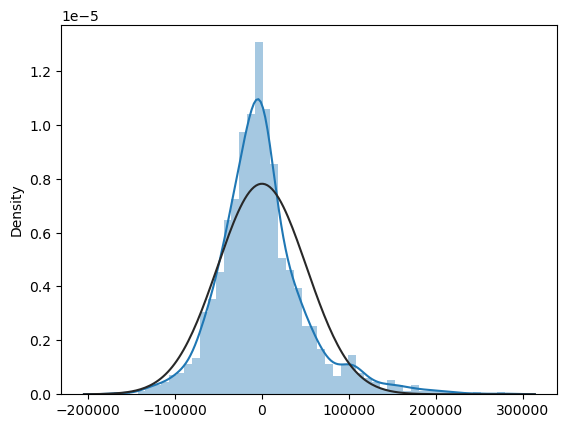

In [267]:
sns.distplot(model15.resid, fit=stats.norm)